In [34]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [35]:

# Load the dataset from a CSV file
csv_file_path = '../dataset/heart_outliers_removed.csv'
data = pd.read_csv(csv_file_path)


In [36]:

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (100, 50,), (200, 50,), (200,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.025, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter':[300, 1000],
    'random_state': [42]
}

# Assume the target column is named 'target' and the rest are features
#X = data.drop(columns=['target'])
X = data[['oldpeak', 'exang', 'cp', 'thalach']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=300, random_state=1)

# Perform grid search
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")

# Use the best estimator to predict
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with best parameters: {accuracy:.2f}")

In [ ]:

# Function to plot learning curve
def epochs_learning_curve(X_train, X_test, y_train, y_test, model_initializer, epochs_sizes=range(1, 250, 25)):
    # Initialize lists to store scores
    train_scores = []
    cv_scores = []
    test_scores = []

    # Loop over different training sizes
    for epochs in epochs_sizes:
        model = model_initializer(epochs)


        #get cross-fold validation score
        cv_score = cross_val_score(model_initializer(epochs), X_train, y_train, cv=5)
        cv_scores.append(cv_score.mean())

        # Train the model on the subset
        model.fit(X_train, y_train)

        # Evaluate on the training subset
        train_pred = model.predict(X_train)
        train_score = accuracy_score(y_train, train_pred)
        train_scores.append(train_score)

        # Evaluate on the full test set
        test_pred = model.predict(X_test)
        test_score = accuracy_score(y_test, test_pred)
        test_scores.append(test_score)

    # Convert scores to numpy arrays for easier handling
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    cv_scores = np.array(cv_scores)

    # Plot the learning curve
    plt.figure()
    plt.title("Learning Curve (MLPClassifier)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.plot(epochs_sizes, train_scores, 'o-', color="r", label="Training Accuracy")
    plt.plot(epochs_sizes, cv_scores, 'o-', color="y", label="CV Accuracy")
    plt.plot(epochs_sizes, test_scores, 'o-', color="g", label="Validation Accuracy")

    plt.legend(loc="best")
    plt.show() 

In [ ]:

# Function to plot learning curve
def epochs_learning_curve(X_train, X_test, y_train, y_test, model_initializer, epochs_sizes=range(1, 250, 25)):
    # Initialize lists to store scores
    train_scores = []
    cv_scores = []
    test_scores = []

    # Loop over different training sizes
    for epochs in epochs_sizes:
        model = model_initializer(epochs)


        #get cross-fold validation score
        cv_score = cross_val_score(model_initializer(epochs), X_train, y_train, cv=5)
        cv_scores.append(cv_score.mean())

        # Train the model on the subset
        model.fit(X_train, y_train)

        # Evaluate on the training subset
        train_pred = model.predict(X_train)
        train_score = accuracy_score(y_train, train_pred)
        train_scores.append(train_score)

        # Evaluate on the full test set
        test_pred = model.predict(X_test)
        test_score = accuracy_score(y_test, test_pred)
        test_scores.append(test_score)

    # Convert scores to numpy arrays for easier handling
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    cv_scores = np.array(cv_scores)

    # Plot the learning curve
    plt.figure()
    plt.title("Learning Curve (MLPClassifier)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.plot(epochs_sizes, train_scores, 'o-', color="r", label="Training Accuracy")
    plt.plot(epochs_sizes, cv_scores, 'o-', color="y", label="CV Accuracy")
    plt.plot(epochs_sizes, test_scores, 'o-', color="g", label="Validation Accuracy")

    plt.legend(loc="best")
    plt.show() 

c:\Users\nicho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nicho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nicho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nicho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization

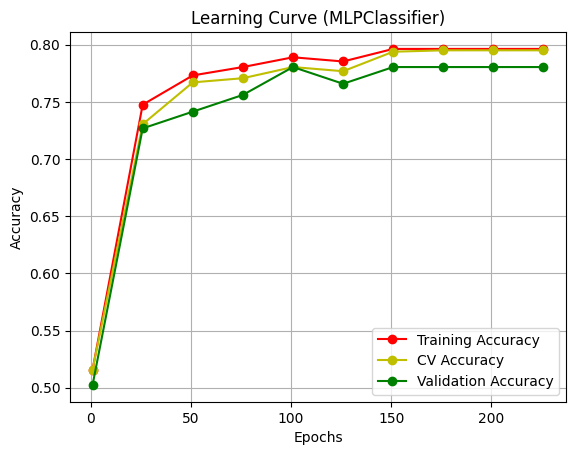

In [ ]:

def model_initializer(epochs):
    params = grid_search.best_params_
    params['max_iter'] = epochs
    return MLPClassifier(**params)
# Plot learning curve
epochs_learning_curve(X_train, X_test, y_train, y_test, model_initializer=model_initializer)
plt.show()